In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cuda', index=0)

In [5]:
noisy_imgs_1, noisy_imgs_2 = torch.load('./drive/MyDrive/data_DL_project/train_data.pkl') #pairs of images with different noises each time
noisy_imgs_1, noisy_imgs_2 = (noisy_imgs_1/255.0 - 0.5), (noisy_imgs_2/255.0 - 0.5)
noisy_imgs_1 = noisy_imgs_1.to(device)
noisy_imgs_2 = noisy_imgs_2.to(device)

In [6]:
val_noisy_imgs, clean_imgs = torch.load('./drive/MyDrive/data_DL_project/val_data.pkl')
val_noisy_imgs = val_noisy_imgs.to(device)
clean_imgs = clean_imgs.to(device)

In [7]:
"""
This file contains all necessary functions and classes to implement the autoencoder described in the paper 
"Noise2Noise: Learning Image Restoration without Clean Data"
Link: https://arxiv.org/abs/1803.04189
"""

import torch
from torch import nn

"""
Describes an "encoding block" in the autoencoder; it's composed of a 3x3 convolutional layer, followed by either
a leaky relu or linear activation layer, and a 2x2 maxpool layer
"""

class EncodingBlock(nn.Module):
    
    def __init__(self, n_in, n_out, dropout = True, p = 0.2):
        super().__init__()
        self.conv = nn.Conv2d(n_in, n_out, kernel_size = 3, padding = 'same', padding_mode = 'zeros')
        self.after = nn.Identity()
        if dropout:
            self.after = nn.Dropout(p = p)
        self.norm = nn.BatchNorm2d(n_out)
        self.pool = nn.MaxPool2d(kernel_size = 2)
        self.activation = nn.LeakyReLU(0.1)
    
    def forward(self,x):
        x = self.conv(x)
        x = self.norm(x)
        x = self.activation(x)
        x = self.after(x)
        x = self.pool(x)
        
        return x
    
"""
Describes an "decoding block" in the autoencoder; it's composed of a 3x3 convolutional layer, followed by either
a leaky relu or linear activation layer, and a 2x2 upsample layer
"""
class DecodingBlock(nn.Module):
    
    def __init__(self, n_in, n_out, dropout = True, p = 0.2):
        super().__init__()
        
        self.conv = nn.Conv2d(n_in, n_out, kernel_size = 3, padding = 'same', padding_mode = 'zeros')
        self.after = nn.Identity()
        if dropout:
            self.after = nn.Dropout(p = p)
        self.norm = nn.BatchNorm2d(n_out)
        self.up = nn.Upsample(scale_factor = 2,mode = 'nearest')
        self.activation = nn.LeakyReLU(0.1)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        x = self.activation(x)
        x = self.up(x)
        x = self.after(x)
        return x
    
"""
Implements the autoencoder
"""
class Noise2Noise(nn.Module):
    
    def __init__(self, n = 3, m = 3):    
        super().__init__()
        #### First layer
        self.conv0 = nn.Conv2d(n, 48, kernel_size = 3, padding = 'same', padding_mode = 'zeros')
        #### ENCODING BLOCKS
        self.encoding1 = EncodingBlock(48, 48)
        self.encoding2 = EncodingBlock(48, 48)
        self.encoding3 = EncodingBlock(48, 48)
        self.encoding4 = EncodingBlock(48, 48)
        self.encoding5 = EncodingBlock(48, 48)
        
        #### DECODING BLOCKS
        self.decoding1 = DecodingBlock(48,48)
        self.deconv1 = nn.Conv2d(96, 96, kernel_size = 3, padding = 'same', padding_mode = 'zeros')
        self.decoding2 = DecodingBlock(96,96)
        self.deconv2 = nn.Conv2d(144, 96, kernel_size = 3, padding = 'same', padding_mode = 'zeros')

        self.decoding3 = DecodingBlock(96,96)
        self.deconv3 = nn.Conv2d(144, 96, kernel_size = 3, padding = 'same')
        self.decoding4 = DecodingBlock(96,96)
        self.deconv4 = nn.Conv2d(144, 96, kernel_size = 3, padding = 'same')
        self.decoding5 = DecodingBlock(96,96)
        
        #### Last layers
        self.conv1 = nn.Conv2d(96 + n, 64, kernel_size = 3, padding = 'same', padding_mode = 'zeros')
        self.conv2 = nn.Conv2d(64, 32, kernel_size = 3, padding = 'same', padding_mode = 'zeros')
        self.conv3 = nn.Conv2d(32, m, kernel_size = 3, padding = 'same', padding_mode = 'zeros')
        
    def forward(self, x):
        input_ = x.detach().clone()
        n = m = 3
        x = self.conv0(x) #enc_conv0
        x = nn.LeakyReLU(0.1)(x)
        #### ENCODING PHASE
        pool1 = self.encoding1(x) #pool1
        pool2 = self.encoding2(pool1) #pool2
        pool3 = self.encoding3(pool2) #pool3
        pool4 = self.encoding4(pool3) #pool4
        pool5 = self.encoding5(pool4) #pool5
        
        
        #### DECODING PHASE
        upsample5 = self.decoding1(pool5)
        concat5 = torch.cat([upsample5,pool4], dim = 1)
        dec_conv5a = self.deconv1(concat5)
        dec_conv5a = nn.LeakyReLU(0.1)(dec_conv5a)
        
        upsample4 = self.decoding2(dec_conv5a)
        concat4 = torch.cat([upsample4,pool3], dim = 1)
        dec_conv4a = self.deconv2(concat4)
        dec_conv4a = nn.LeakyReLU(0.1)(dec_conv4a)
        
        upsample3 = self.decoding3(dec_conv4a)
        concat3 = torch.cat([upsample3,pool2], dim = 1)
        dec_conv3a = self.deconv3(concat3)
        dec_conv3a = nn.LeakyReLU(0.1)(dec_conv3a)
        
        upsample2 = self.decoding4(dec_conv3a)
        concat2 = torch.cat([upsample2,pool1], dim = 1)
        dec_conv2a = self.deconv4(concat2)
        dec_conv2a = nn.LeakyReLU(0.1)(dec_conv2a)
        
        
        upsample1 = self.decoding5(dec_conv2a)
        concat1 = torch.cat([upsample1,input_], dim = 1)
        
        
        #### Last phase
        r = self.conv1(concat1)
        r = nn.LeakyReLU(0.1)(r)
        
        r = self.conv2(r)
        r = nn.LeakyReLU(0.1)(r)
        
        r = self.conv3(r)
        return r

In [8]:
#noisy_imgs_1 = noisy_imgs_1[:4000]
#noisy_imgs_2 = noisy_imgs_2[:4000]

In [9]:
val_imgs_during_training = val_noisy_imgs[800:]
clean_imgs_during_training = clean_imgs[800:]

In [10]:
from torch import optim
import time

In [ ]:
def validation_check(model):
    with torch.no_grad():
        denoised = ((model(val_imgs_during_training/255 -0.5)))
        mse = torch.mean( (torch.clamp((denoised + 0.5)*255, min = 0, max = 255) - (clean_imgs_during_training) )**2 )
        return mse
import copy
model = Noise2Noise()
model = model.to(device)
loss = nn.L1Loss().to(device)
epochs = 30
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.99), eps=1e-08, weight_decay=0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',  verbose=True,patience=4)
N = noisy_imgs_1.size(0)
batch_size = 32
#Early stopping
last_loss = float("inf")
best_model = copy.deepcopy(model)
patience = 6
trigger = 0
for e in range(epochs):
    t = time.time()
    
    for index in range(0, N, batch_size):
        optimizer.zero_grad()
        train_data_minibatch = noisy_imgs_1[index:(index+batch_size)]
        train_target_minibatch = noisy_imgs_2[index:(index+batch_size)]
        loss(model(train_data_minibatch), train_target_minibatch).backward()
        optimizer.step()
    val_loss = validation_check(model)
    scheduler.step(val_loss)
    if val_loss > last_loss:
        trigger += 1
        if trigger == patience:
            break
    else:
        last_loss = val_loss
        best_model = copy.deepcopy(model)
        trigger = 0
        print(e)
        print("epoch time : "str(time.time() - t))
model = best_model

0
10
Epoch    14: reducing learning rate of group 0 to 1.0000e-05.
20
Epoch    25: reducing learning rate of group 0 to 1.0000e-06.


In [ ]:
with torch.no_grad():
  output = ((model(val_noisy_imgs[:10]/255 - 0.5)))
  output = torch.clamp((output + 0.5)*255, min = 0, max = 255).int()

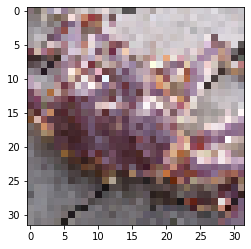

In [ ]:
plt.imshow(  val_noisy_imgs[0].cpu().detach().permute(1, 2, 0))

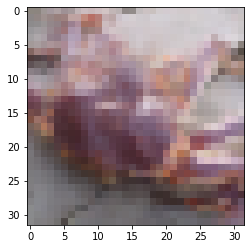

In [ ]:
plt.imshow(  output[0].cpu().detach().permute(1, 2, 0))

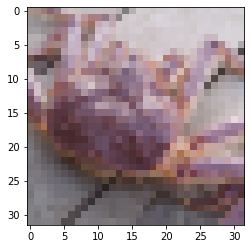

In [ ]:
plt.imshow( clean_imgs[0].cpu().detach().permute(1, 2, 0) )